# Define the system  

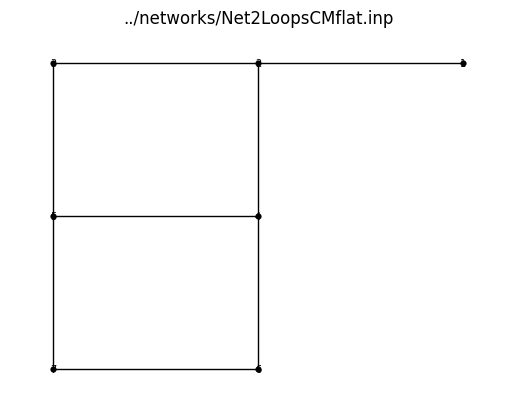

<Axes: title={'center': '../networks/Net2LoopsCMflat.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np
import os 

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# Create a water network model
# inp_file = '../networks/Net0.inp'
# inp_file = '../networks/Net2LoopsDW.inp'
inp_file = '../networks/Net2LoopsCMflat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

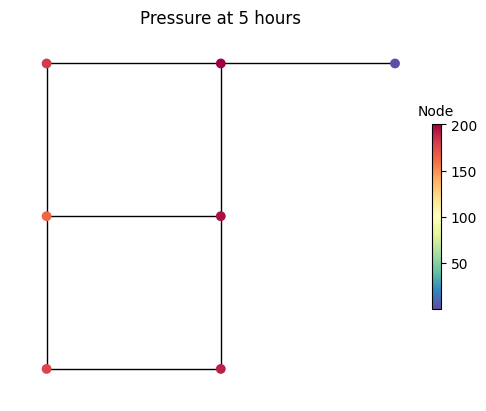

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
inp_file = '../networks/Net2LoopsCMflat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
# sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
results.link["flowrate"]

name,1,2,3,4,5,6,7,8
0,0.31109,0.051113,0.232207,0.031075,0.167802,0.076132,0.023343,-0.020582


In [4]:
ref_pressure = results.node['pressure'].values[0][:-1]
ref_pressure

array([200.733, 181.735, 195.558, 163.834, 190.505, 177.75 ], dtype=float32)

In [5]:
results.node['pressure']

name,2,3,4,5,6,7,1
0,200.732986,181.735184,195.55777,163.834244,190.504684,177.750153,4.394531e-07


In [6]:
ref_rate = results.link['flowrate'].values[0]
ref_rate = ref_rate[[0,1,2,6,3,4,7,5]]

In [7]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  2.334e-02,  3.108e-02,  1.678e-01, -2.058e-02,  7.613e-02,  2.007e+02,  1.817e+02,  1.956e+02,  1.638e+02,  1.905e+02,  1.778e+02], dtype=float32)

## Run with the QUBO Polynomial Solver

In [8]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [78]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (15/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=0, var_base_name="x")

nqbit = 5
step = (300/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+500.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 500.000000 => 800.000000 (res: 9.677419)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.483871)


In [79]:
net.convert_solution_from_si(ref_values)

array([ 10.986,   1.805,   8.2  ,   0.824,   1.097,   5.926,  -0.727,   2.689, 658.573, 596.244, 641.594, 537.514, 625.015, 583.17 ], dtype=float32)

Solve the system classically

In [80]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)
net.verify_solution(net.convert_solution_from_si(ref_values))

ref_sol, cvg = net.classical_solutions(max_iter = 100, tol= 1e-3)
ref_sol[[0,1,2,6,3,4,7,5]] / ref_values[:8]

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999, 1.   ])

In [130]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import RandomSampler
from dwave.samplers import TabuSampler
from dwave.samplers import TreeDecompositionSampler

sampler = SimulatedAnnealingSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model, strength=1E8, num_reads=100000,  options={"sampler" : sampler, })
sol = net.extract_data_from_model(model)

In [131]:
net.convert_solution_from_si(sol)

array([ 1.452e+01,  4.839e-01,  6.774e+00, -4.839e-01,  4.355e+00,  5.323e+00, -4.839e-01,  1.452e+00,  6.645e+02,  6.645e+02,  6.645e+02,  6.839e+02,  6.548e+02,  5.000e+02])

In [132]:
net.qubo.verify_quadratic_constraints(net.sampleset.lowest())

/tmp/ipykernel_5416/1944863955.py:2: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  g = net.qubo.qubo_dict.to_networkx_graph()


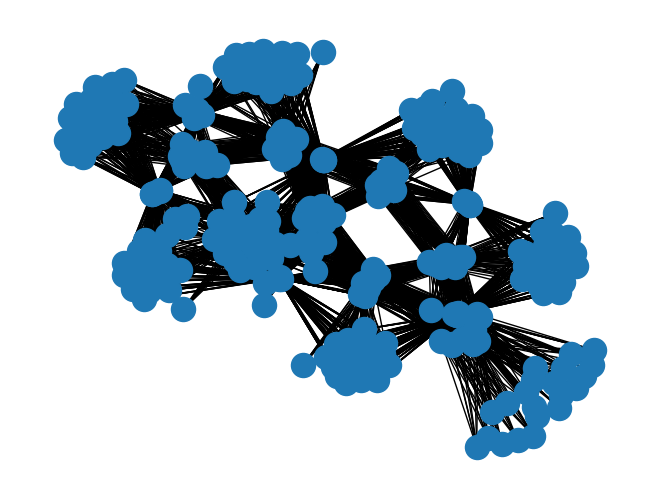

In [133]:
import networkx as nx 
g = net.qubo.qubo_dict.to_networkx_graph()
nx.draw(g, pos = nx.spring_layout(g))

In [134]:
np.array(sol)[:8]

array([ 0.411,  0.014,  0.192, -0.014,  0.123,  0.151, -0.014,  0.041])

In [135]:
ref_sol[:8]

array([ 0.311,  0.051,  0.232,  0.031,  0.168,  0.076,  0.023, -0.021])

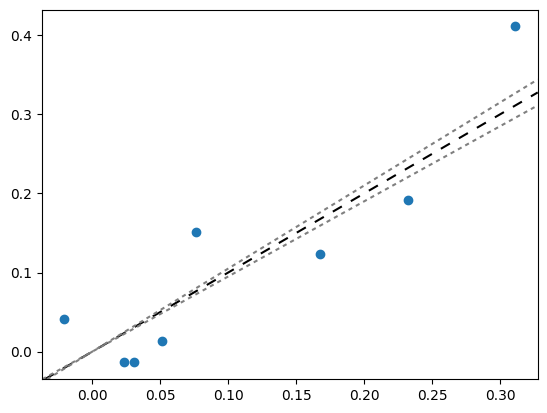

In [136]:
import matplotlib.pyplot as plt 
plt.scatter( ref_sol[:8], np.array(sol)[:8])
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))

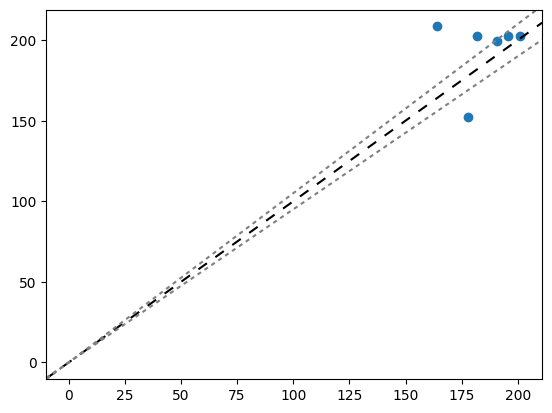

In [137]:
import matplotlib.pyplot as plt 
plt.scatter(ref_sol[8:], np.array(sol)[8:])
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))

In [98]:
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  2.334e-02,  3.108e-02,  1.678e-01, -2.058e-02,  7.613e-02,  2.007e+02,  1.817e+02,  1.956e+02,  1.638e+02,  1.905e+02,  1.778e+02], dtype=float32)

In [99]:
net.diagnostic_solution(sol, ref_sol)

Head Encoding : 500.000000 => 800.000000 (res: 9.677419)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.483871)


Error (%): [  0.      0.    200.    100.    200.      0.    200.    200.    -10.11   19.59  -29.818 100.     67.336 -44.002 -17.364 -33.224   4.988   3.223  -0.534 -19.861  -3.191   4.372]


sol :  [  1.      1.     -1.      0.     -1.      1.     -1.      1.     12.097   1.452  10.645   0.      1.935   3.871   0.968   0.968 625.806 577.419 645.161 645.161 645.161 558.065]
ref :  [  1.      1.      1.      1.      1.      1.      1.     -1.     10.986   1.805   8.2     1.098   5.925   2.688   0.825   0.726 658.662 596.652 641.733 538.256 625.212 583.576]
diff:  [   0.       0.       2.       1.       2.       0.       2.      -2.      -1.111    0.354   -2.445    1.098    3.99    -1.183   -0.143   -0.241   32.855   19.233   -3.428 -106.905  -19.95    25.511]


encoded_sol:  [  1.      1.     -1.     -1.     -1.      1.     -1.      1.     12.097   1.

# Run with the intergrated WNTR Solver

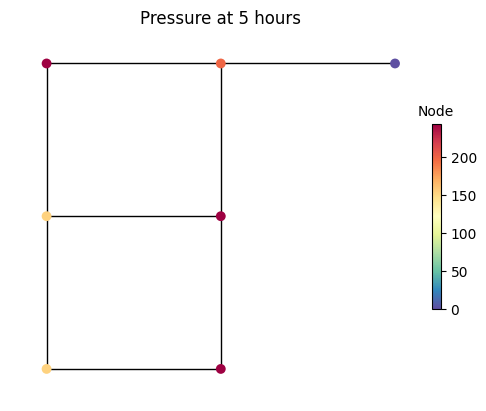

<Axes: title={'center': 'Pressure at 5 hours'}>

In [22]:
sim = wntr_quantum.sim.FullQuboPolynomialSimulator(wn, 
                                                   flow_encoding=flow_encoding, 
                                                   head_encoding=head_encoding)
results = sim.run_sim(solver_options={"sampler" : sampler})

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [140]:
import dimod
import hybrid

# Construct a problem
bqm = dimod.BinaryQuadraticModel({}, {'ab': 1, 'bc': -1, 'ca': 1}, 0, dimod.SPIN)

# Define the workflow
iteration = hybrid.RacingBranches(
    hybrid.InterruptableTabuSampler(),
    hybrid.decomposers.EnergyImpactDecomposer(size=2)
    | hybrid.TabuProblemSampler(num_reads=2)
    | hybrid.SplatComposer()
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
print("Solution: sample={.samples.first}".format(final_state))

StateTraitMissingError: input state is missing 'subsamples' on SplatComposer()